<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   float64
 1   survived   1309 non-null   float64
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   float64
 6   parch      1309 non-null   float64
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(7), object(7)
memory usage: 143.4+ KB
None
             pclass     survived                  name   sex          age  \
count   1309.000000  1309.000000                  1309  1309  1046.000000   
unique          NaN          NaN        

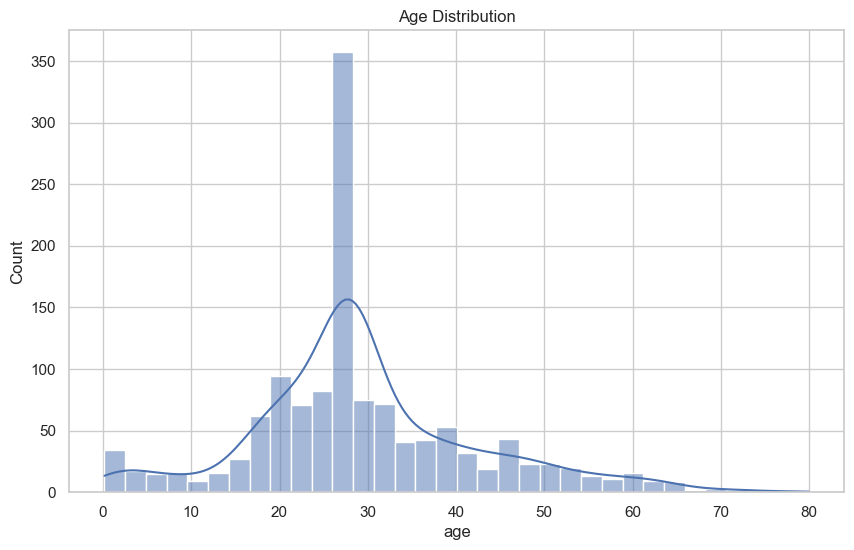

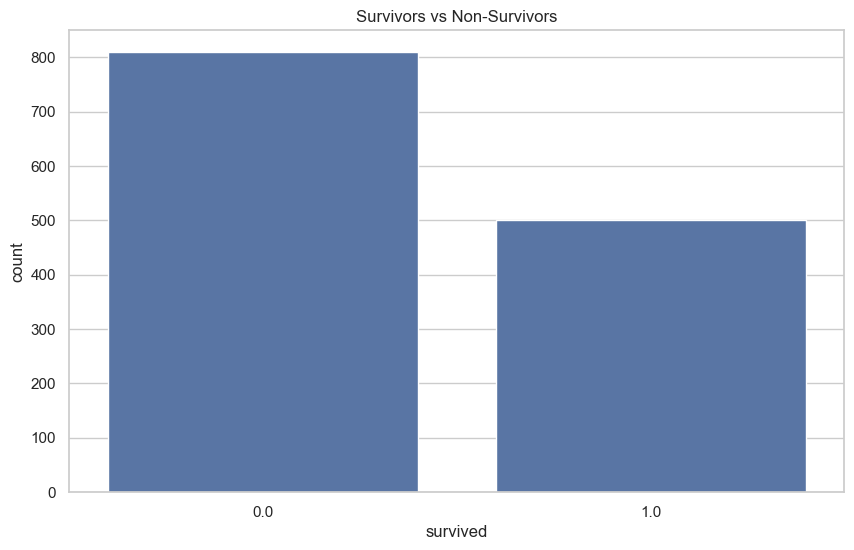

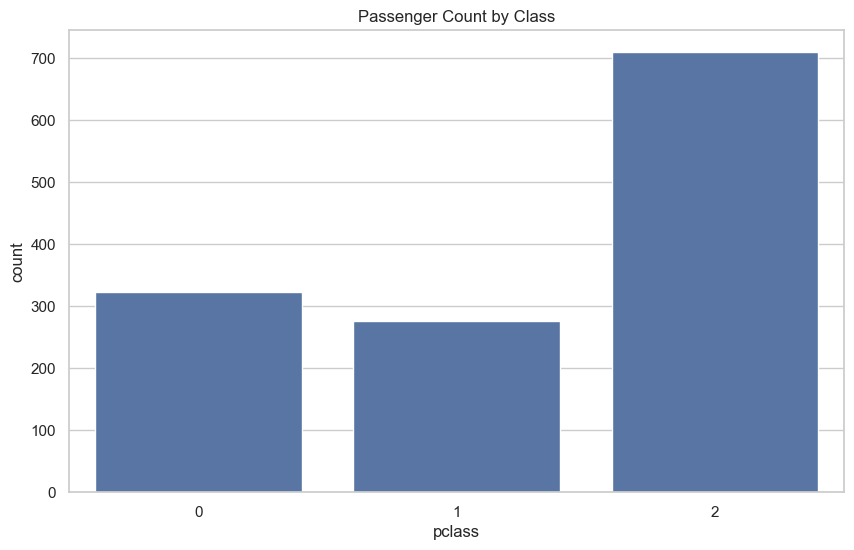

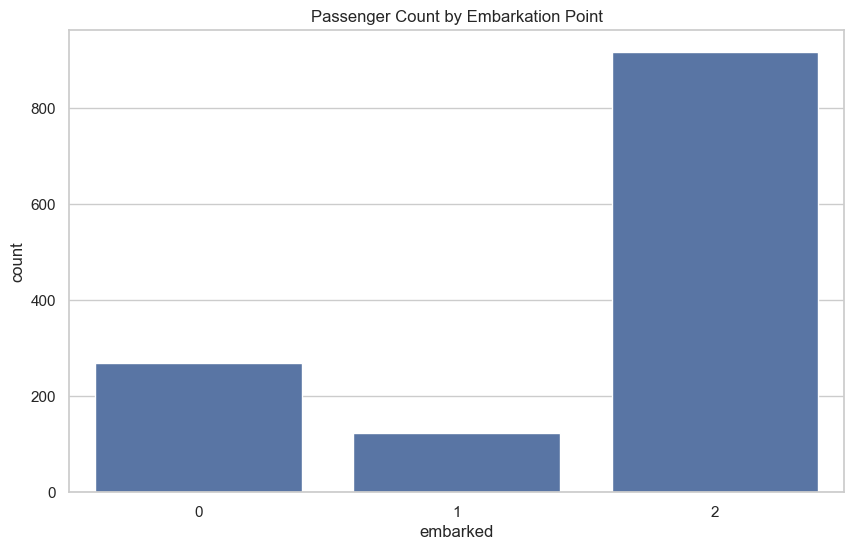

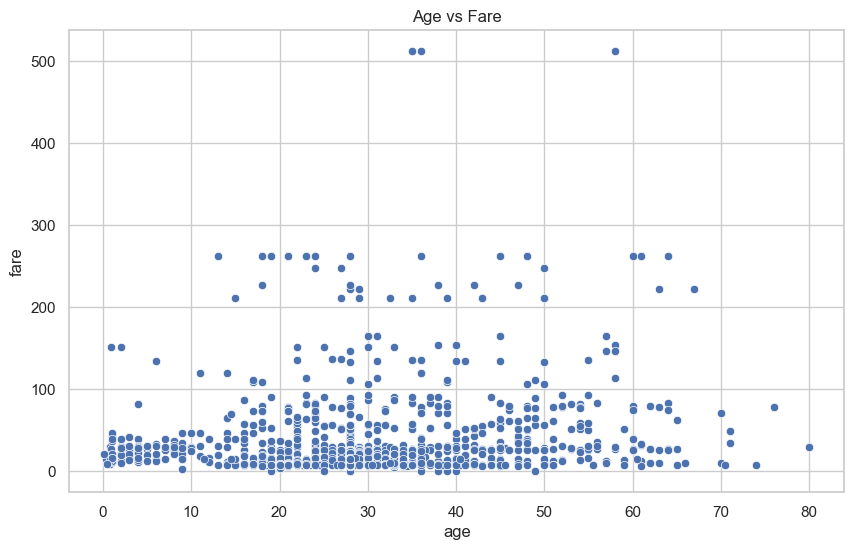

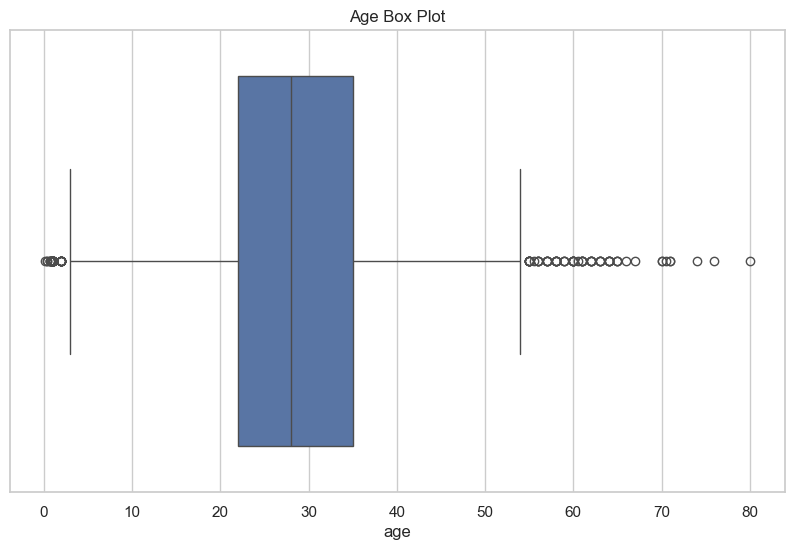

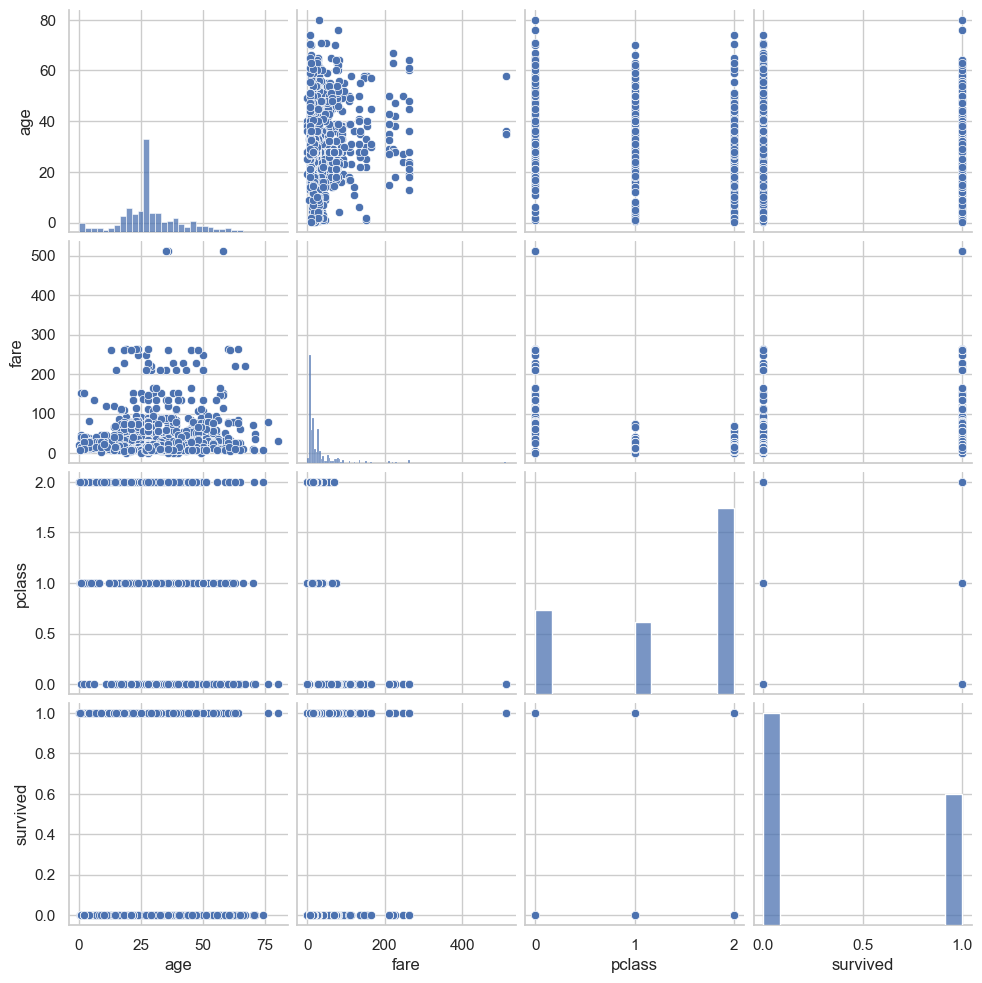

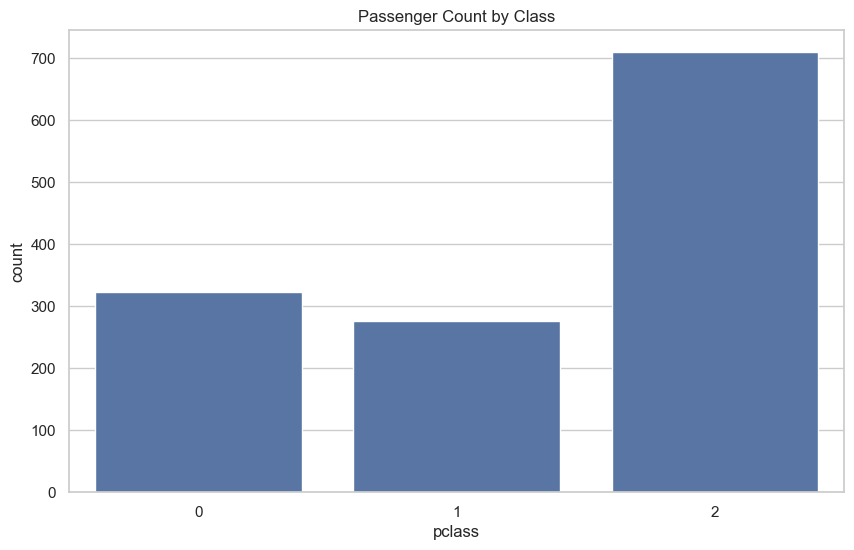

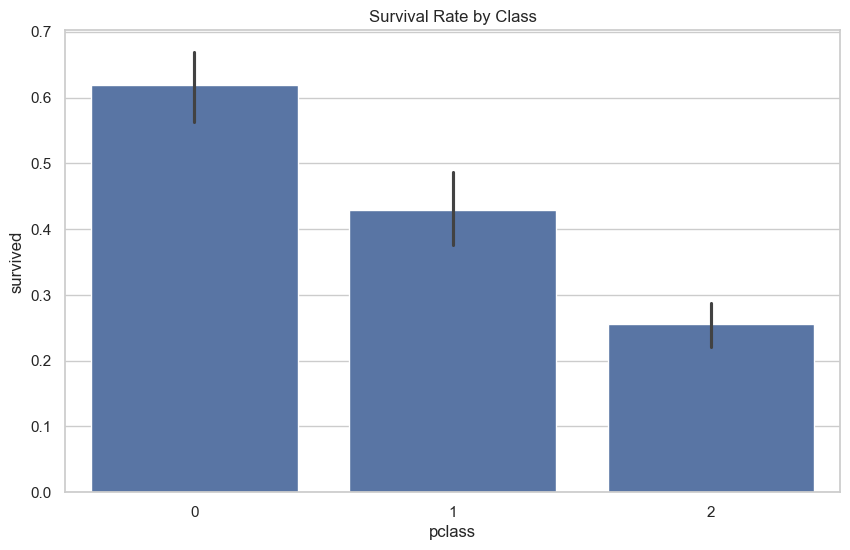

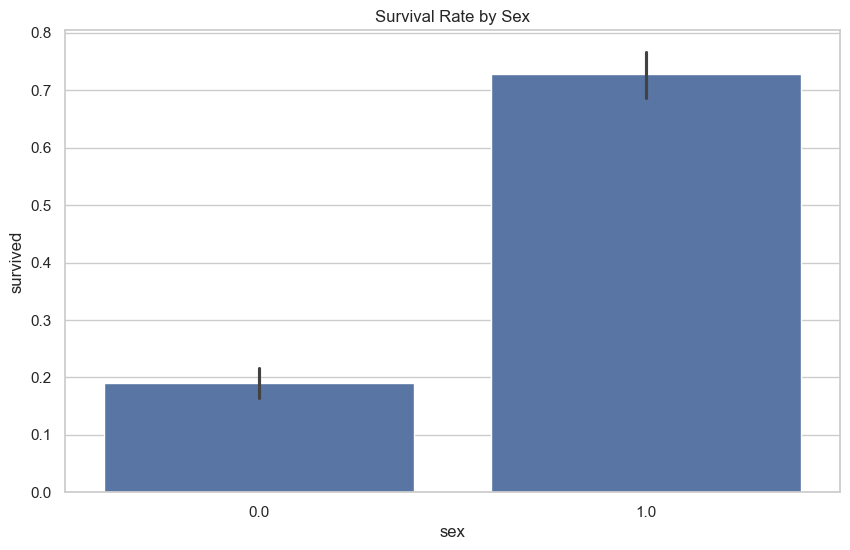

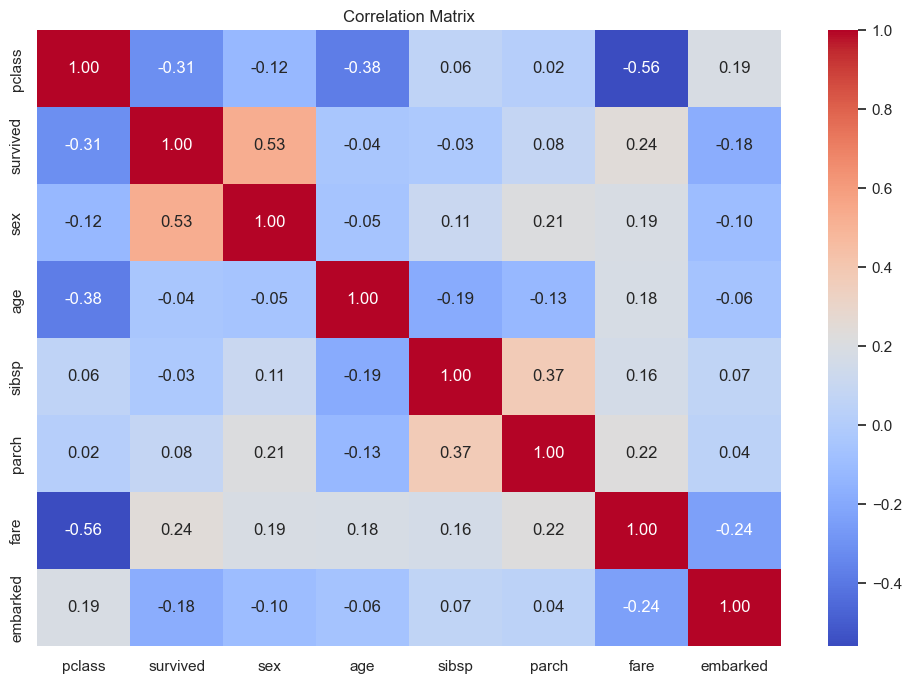

Logistic Regression selected features:  Index(['pclass', 'sex', 'age', 'sibsp', 'embarked'], dtype='object')
Random Forest selected features:  Index(['pclass', 'sex', 'age', 'sibsp', 'fare'], dtype='object')
Gradient Boosting selected features:  Index(['pclass', 'sex', 'age', 'sibsp', 'fare'], dtype='object')
Best Logistic Regression parameters:  {'C': 0.1}
Best Random Forest parameters:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best Gradient Boosting parameters:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Logistic Regression cross-validation accuracy:  0.7977102313956301
Random Forest cross-validation accuracy:  0.8053212932355075
Gradient Boosting cross-validation accuracy:  0.8078690639361445
Test set accuracy:  0.7977099236641222
Confusion Matrix:
 [[137  14]
 [ 39  72]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.91      0.84       151
         1.0       0.84      0.65      0.73 

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from lightgbm import LGBMClassifier

titanic = pd.read_csv("titanic.csv")
titanic.head()
print(titanic.info())
print(titanic.describe(include='all'))

titanic['pclass'] = titanic['pclass'].replace(-1, np.nan)
titanic['pclass'] = titanic['pclass'].fillna(titanic['pclass'].mode()[0])

# Verify that there are no more junk values in 'pclass'
print(titanic['pclass'].value_counts())

titanic['age'] = titanic['age'].fillna(titanic['age'].median())
titanic['fare'] = titanic['fare'].fillna(titanic['fare'].median())
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])

# Drop columns with too many missing values
titanic.drop(columns=['cabin', 'boat', 'body', 'home.dest'], inplace=True)

# Convert categorical columns to numerical
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic['pclass'] = titanic['pclass'].astype('category').cat.codes

# Drop irrelevant columns
titanic.drop(columns=['name', 'ticket'], inplace=True)

# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X = titanic.drop('survived', axis=1)
y = titanic['survived']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the first few rows of the training set to ensure data is clean
print(X_train.head())
print(y_train.head())

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(titanic['age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='survived', data=titanic)
plt.title('Survivors vs Non-Survivors')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='pclass', data=titanic)
plt.title('Passenger Count by Class')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='embarked', data=titanic)
plt.title('Passenger Count by Embarkation Point')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='fare', data=titanic)
plt.title('Age vs Fare')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='age', data=titanic)
plt.title('Age Box Plot')
plt.show()

sns.pairplot(titanic[['age', 'fare', 'pclass', 'survived']])
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='pclass', data=titanic)
plt.title('Passenger Count by Class')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='pclass', y='survived', data=titanic)
plt.title('Survival Rate by Class')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='sex', y='survived', data=titanic)
plt.title('Survival Rate by Sex')
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = titanic.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

logreg = LogisticRegression(max_iter=200)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Feature selection with RFE
rfe_logreg = RFE(logreg, n_features_to_select=5)
rfe_rf = RFE(rf, n_features_to_select=5)
rfe_gb = RFE(gb, n_features_to_select=5)

rfe_logreg.fit(X_train, y_train)
rfe_rf.fit(X_train, y_train)
rfe_gb.fit(X_train, y_train)

logreg_selected_features = X_train.columns[rfe_logreg.support_]
rf_selected_features = X_train.columns[rfe_rf.support_]
gb_selected_features = X_train.columns[rfe_gb.support_]

print("Logistic Regression selected features: ", logreg_selected_features)
print("Random Forest selected features: ", rf_selected_features)
print("Gradient Boosting selected features: ", gb_selected_features)

param_grid_logreg = {
    'C': [0.1, 1, 10, 100]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, scoring='accuracy')
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy')

grid_logreg.fit(X_train[logreg_selected_features], y_train)
grid_rf.fit(X_train[rf_selected_features], y_train)
grid_gb.fit(X_train[gb_selected_features], y_train)

best_logreg = grid_logreg.best_estimator_
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_

print("Best Logistic Regression parameters: ", grid_logreg.best_params_)
print("Best Random Forest parameters: ", grid_rf.best_params_)
print("Best Gradient Boosting parameters: ", grid_gb.best_params_)

# Cross-validation
cv_logreg = cross_val_score(best_logreg, X_train[logreg_selected_features], y_train, cv=5, scoring='accuracy')
cv_rf = cross_val_score(best_rf, X_train[rf_selected_features], y_train, cv=5, scoring='accuracy')
cv_gb = cross_val_score(best_gb, X_train[gb_selected_features], y_train, cv=5, scoring='accuracy')

print("Logistic Regression cross-validation accuracy: ", cv_logreg.mean())
print("Random Forest cross-validation accuracy: ", cv_rf.mean())
print("Gradient Boosting cross-validation accuracy: ", cv_gb.mean())

# Evaluate the best model on the test set
best_model = best_gb  # Assuming Gradient Boosting performed best
y_pred = best_model.predict(X_test[gb_selected_features])

print("Test set accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))